# Inference


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/machine-translation-testing

/content/drive/MyDrive/machine-translation-testing


In [3]:
!ls

 args.py		       lang_obj.pkl     saved_models
 bleu_score.py		       nnet_models.py   train_attention.py
 data			       plots_dir        train_utilities.py
 dataset_helper.py	       plot_test.py     utils.py
 global_variables.py	       plotting.ipynb
'Hyperparameter Tuning.xlsx'   __pycache__


In [4]:
# =============== Import Modules ==============
import os
import time
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from functools import partial
import sys
import logging as log
from datetime import datetime as dt
import time
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import math
import copy
from collections import namedtuple
from tqdm import notebook

In [5]:
# =============== Self Defined ===============
from args import args, check_args
import dataset_helper
import nnet_models
import train_utilities
import global_variables
import utils

In [6]:
project_dir = '/content/drive/MyDrive/machine-translation-testing/'
plots_dir = os.path.join(project_dir, 'plots_dir')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_name = 'vi'
target_name = 'en'
main_data_path = os.path.join(project_dir,'data/iwslt-v-en/')
base_saved_models_dir = os.path.join(project_dir,'saved_models/')
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)
bs = 128
enc_emb = 512
enc_hidden = 512
enc_layers = 1
rnn_type = 'lstm'
dec_emb = 512
dec_hidden = 1024
dec_layers = 1

learning_rate = 0.25
num_epochs = 15
attn_flag = True
beam_size = 3

In [8]:
# get data paths
path_to_train_data = {'source':main_data_path+'train.tok.'+source_name, 'target':main_data_path+'train.tok.'+target_name}
path_to_dev_data = {'source': main_data_path+'dev.tok.'+source_name, 'target':main_data_path+'dev.tok.'+target_name}
path_to_test_data = {'source': main_data_path+'test.tok.'+source_name, 'target':main_data_path+'test.tok.'+target_name}

In [9]:
train, val, test, en_lang, vi_lang = dataset_helper.train_val_load("", main_data_path)

In [10]:
print("English has a vocab size of {}.".format(en_lang.n_words))
print("Vietnamese has a vocab size of {}.".format(vi_lang.n_words))

English has a vocab size of 15915.
Vietnamese has a vocab size of 13263.


In [11]:
MAX_LEN = int(train['en_len'].quantile(0.95))

In [12]:
bs_dict = {'train':bs, 'validate':1, 'test':1}
shuffle_dict = {'train':True, 'validate':False, 'test':False}

train_used = train
val_used = val

collate_fn_dict = {'train':partial(dataset_helper.vocab_collate_func, MAX_LEN = MAX_LEN), 'validate':dataset_helper.vocab_collate_func_val, 'test': dataset_helper.vocab_collate_func_val}

transformed_dataset = {'train': dataset_helper.Vietnamese(train_used), 'validate': dataset_helper.Vietnamese(val_used, val = True), 'test':dataset_helper.Vietnamese(test, val= True)}

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs_dict[x], collate_fn=collate_fn_dict[x], shuffle=shuffle_dict[x], num_workers=0) for x in ['train', 'validate', 'test']} 

In [13]:
encoder_w_att = nnet_models.EncoderRNN(input_size = vi_lang.n_words, embed_dim = enc_emb, hidden_size = enc_hidden, n_layers=enc_layers, rnn_type=rnn_type).to(device)
decoder_w_att = nnet_models.AttentionDecoderRNN(output_size = en_lang.n_words, embed_dim = dec_emb, hidden_size = dec_hidden, n_layers = dec_layers, attention = attn_flag).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [14]:
encoder_wo_att = nnet_models.EncoderRNN(input_size = vi_lang.n_words, embed_dim = enc_emb, hidden_size = enc_hidden, n_layers=enc_layers, rnn_type=rnn_type).to(device)
decoder_wo_att = nnet_models.AttentionDecoderRNN(output_size = en_lang.n_words, embed_dim = dec_emb, hidden_size = dec_hidden, n_layers = dec_layers, attention = False).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [15]:
optimizer = 'sgd'

if optimizer == 'sgd':
  encoder_optimizer = optim.SGD(encoder_w_att.parameters(), lr = learning_rate, nesterov = True, momentum = 0.99)
  decoder_optimizer = optim.SGD(decoder_w_att.parameters(), lr = learning_rate,nesterov = True, momentum = 0.99)
elif optimizer == 'adam':
  encoder_optimizer = optim.Adam(encoder_w_att.parameters(), lr = 5e-3)
  decoder_optimizer = optim.Adam(decoder_w_att.parameters(), lr = 5e-3)
else:
		raise ValueError('Invalid optimizer!')

In [16]:
enc_scheduler = ReduceLROnPlateau(encoder_optimizer, min_lr=1e-4, factor = 0.5, patience=0)
dec_scheduler = ReduceLROnPlateau(decoder_optimizer, min_lr=1e-4, factor = 0.5, patience=0)
criterion = nn.NLLLoss(ignore_index = global_variables.PAD_IDX)

In [17]:
#encoder_save = '{}_att_{}_enc_{}_layer'.format(rnn_type, optimizer, enc_layers)
#decoder_save = '{}_att_{}_dec_{}_layer'.format(rnn_type, optimizer, dec_layers)

In [18]:
# load attn model
encoder_w_att.load_state_dict(torch.load('/content/drive/MyDrive/machine-translation-testing/saved_models/attn_lstm_128bs_512hs_512em_sgd_5beam_1layer/lstm_att_128bs_512hs_sgd_5beam_enc_1_layer.pth'))
decoder_w_att.load_state_dict(torch.load('/content/drive/MyDrive/machine-translation-testing/saved_models/attn_lstm_128bs_512hs_512em_sgd_5beam_1layer/lstm_att_128bs_512hs_sgd_5beam_dec_1_layer.pth'))

<All keys matched successfully>

In [19]:
# load no attn model
encoder_wo_att.load_state_dict(torch.load('/content/drive/MyDrive/machine-translation-testing/saved_models/wo_attn_lstm_128bs_512hs_512em_sgd_5beam_1layer/lstm_wo_att_128bs_512hs_sgd_5beam_enc_1_layer.pth'))
decoder_wo_att.load_state_dict(torch.load('/content/drive/MyDrive/machine-translation-testing/saved_models/wo_attn_lstm_128bs_512hs_512em_sgd_5beam_1layer/lstm_wo_att_128bs_512hs_sgd_5beam_dec_1_layer.pth'))

<All keys matched successfully>

In [20]:
def get_binned_bl_score(encoder, decoder, val_dataset, attn_flag, beam_size, location, collate, lang_en, lang_vi, min_len = 0, max_len = 30):
	
  '''
	return plot for binned bleu scores
	'''
  plt.style.use('seaborn-white')
  attn_str = 'attention' if attn_flag == True else 'no_attention'

  # set bins
  len_threshold = np.arange(min_len, max_len + 1, 5)
  # intiate bleu score list
  bin_bl_score = np.zeros(len(len_threshold))

  for i in notebook.tqdm(range(1, len(len_threshold)), total = len(len_threshold) - 1):
    # set lower and upper bound buckets
    lower_bound = len_threshold[i-1]
    upper_bound = len_threshold[i]

    # subset val df
    temp_dataset = copy.deepcopy(val_dataset);
    temp_dataset.df = temp_dataset.df[(temp_dataset.df['vi_len'] > lower_bound) & (temp_dataset.df['vi_len'] <= upper_bound)];

    # val dataloader
    temp_loader = DataLoader(temp_dataset, batch_size = 1, collate_fn = collate, shuffle = False, num_workers=0)

    # evaluate
    bin_bl_score[i], _, _, _ = train_utilities.validation_beam_search(encoder, decoder, temp_loader, lang_en, lang_vi, attn_str, beam_size, verbose = False)

  # plot bleu score vs. sent lengh
  len_threshold = len_threshold[1:]
  bin_bl_score = bin_bl_score[1:]
  fig = plt.figure()
  plt.plot(len_threshold, bin_bl_score, '--x', markersize=10)
  plt.ylim(0, np.max(bin_bl_score)+1)
  plt.xlabel('sentence length')
  plt.ylabel('BLEU score')
  plt.title('BLEU Score vs. Sentence Length')
  fig.tight_layout()
  #fig.savefig(os.path.join(location,'binned_bl_score_{}.png'.format(time.strftime("%Y%m%d-%H.%M.%S"))))

  return len_threshold, bin_bl_score, fig

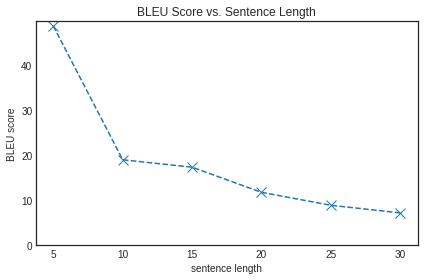

In [21]:
rnn_len_threshold, rnn_bin_bl, fig1 = get_binned_bl_score(encoder = encoder_wo_att, decoder = decoder_wo_att, val_dataset = transformed_dataset['validate'], attn_flag = False, beam_size = beam_size, location = plots_dir, collate = collate_fn_dict['validate'], lang_en = en_lang, lang_vi = vi_lang)


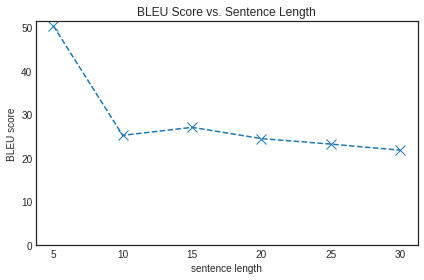

In [22]:
attn_len_threshold, attn_bin_bl, fig2 = get_binned_bl_score(encoder = encoder_w_att, decoder = decoder_w_att, val_dataset = transformed_dataset['validate'], attn_flag = attn_flag, beam_size = beam_size, location = plots_dir, collate = collate_fn_dict['validate'], lang_en = en_lang, lang_vi = vi_lang)


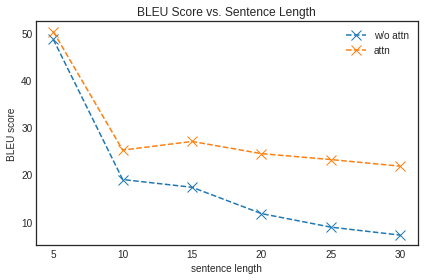

In [23]:
plt.style.use('seaborn-white')
plt.plot(rnn_len_threshold, rnn_bin_bl, '--x', markersize=10, label = 'w/o attn')
plt.plot(attn_len_threshold, attn_bin_bl, '--x', markersize=10, label = 'attn')
plt.xlabel('sentence length')
plt.ylabel('BLEU score')
plt.title('BLEU Score vs. Sentence Length')
plt.tight_layout()
plt.legend()
plt.show()

In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    plt.style.use('default')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    attentions = attentions.cpu().squeeze(1).detach().numpy()
    cax = ax.matshow(attentions, cmap='copper', aspect='auto')
 
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       ['<EOS>']);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [25]:
bleu_no_unk, att_score_wo, pred_wo, src_wo = train_utilities.validation_beam_search(encoder_w_att, decoder_w_att, dataloader['validate'], en_lang, vi_lang, 'attention', beam_size, verbose = False)

In [26]:
bleu_no_unk

23.557189110604167

In [30]:
# get 5 indexes for short sentences
count = 0
for i in range(len(pred_wo)):
  if count == 5:
    break
  if len(pred_wo[i]) < 30:
    print(i, end = ',')
    count += 1
    

9,21,35,38,74,

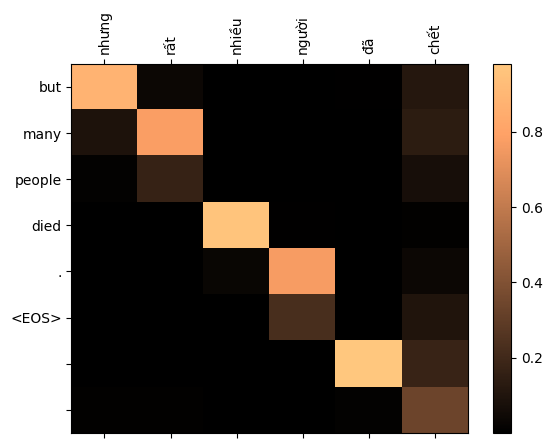

In [28]:
n = 21
showAttention(src_wo[n],pred_wo[n], att_score_wo[n])